In [1]:
import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

import utils
plt.rcParams['figure.figsize'] = (20, 10)
plt.rc('font', size=13)

In [2]:
features = utils.load('fma_metadata/features.csv')
tracks = utils.load('fma_metadata/tracks.csv')

In [3]:
features_m = features[tracks['set','subset']<='medium']
tracks_m = tracks[tracks['set','subset']<='medium']

In [4]:
corr_matrix = features_m.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.60)]
features_m.drop(to_drop, axis=1, inplace=True)

C:\Users\polpo\anaconda3\envs\fma\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
features_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 2 to 155314
Columns: 191 entries, ('chroma_cens', 'kurtosis', '01') to ('zcr', 'kurtosis', '01')
dtypes: float64(191)
memory usage: 36.6 MB


In [6]:
features_m['genre'] = tracks['track','genre_top']

<ipython-input-6-e9b81a991e64>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_m['genre'] = tracks['track','genre_top']


In [7]:
le = LabelEncoder()
features_m['genre'] = le.fit_transform(features_m['genre'])
features_m['genre']

<ipython-input-7-288eb629b543>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_m['genre'] = le.fit_transform(features_m['genre'])


track_id
2          7
3          7
5          7
10        12
134        7
          ..
155297     8
155298     6
155306     6
155307     5
155314    13
Name: genre, Length: 25000, dtype: int32

In [8]:
le.classes_

array(['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic',
       'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International',
       'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken'],
      dtype=object)

In [9]:
attributes = [col for col in features_m.columns if col != ('genre', '', '')]

In [10]:
X = features_m[attributes].values
y = features_m[('genre', '', '')]

In [11]:
sel = SelectKBest(k=20)
X_sel = sel.fit_transform(X, y)
X_sel.shape

(25000, 20)

In [12]:
feat_importance= dict(zip(features_m.columns, sel.scores_))

In [13]:
sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)[:20]

[(('mfcc', 'max', '04'), 858.7115328485435),
 (('mfcc', 'max', '01'), 768.1876850328108),
 (('mfcc', 'max', '03'), 416.79310438632905),
 (('mfcc', 'max', '07'), 384.3081626020349),
 (('spectral_bandwidth', 'kurtosis', '01'), 357.20514552817275),
 (('mfcc', 'mean', '02'), 340.05550305373316),
 (('chroma_stft', 'mean', '01'), 290.38052066427),
 (('mfcc', 'std', '04'), 281.83990740342057),
 (('mfcc', 'std', '02'), 280.3960742957319),
 (('spectral_contrast', 'max', '04'), 267.937144552194),
 (('mfcc', 'min', '04'), 265.648429894638),
 (('mfcc', 'std', '01'), 258.5105522377112),
 (('mfcc', 'skew', '04'), 247.34800125416925),
 (('mfcc', 'min', '05'), 247.15955683445324),
 (('spectral_contrast', 'max', '03'), 240.3688867546301),
 (('mfcc', 'min', '02'), 234.0722959609404),
 (('mfcc', 'max', '11'), 221.97834966485144),
 (('tonnetz', 'std', '01'), 218.3906700859561),
 (('spectral_contrast', 'min', '02'), 216.42335587533182),
 (('mfcc', 'min', '11'), 208.4283609975846)]

In [14]:
attributes_sel= features_m[attributes].columns[sel.get_support()]
attributes_sel

MultiIndex([(       'chroma_stft',     'mean', '01'),
            (              'mfcc',      'max', '01'),
            (              'mfcc',      'max', '03'),
            (              'mfcc',      'max', '04'),
            (              'mfcc',      'max', '07'),
            (              'mfcc',      'max', '11'),
            (              'mfcc',     'mean', '02'),
            (              'mfcc',      'min', '02'),
            (              'mfcc',      'min', '04'),
            (              'mfcc',      'min', '05'),
            (              'mfcc',      'min', '11'),
            (              'mfcc',     'skew', '04'),
            (              'mfcc',      'std', '01'),
            (              'mfcc',      'std', '02'),
            (              'mfcc',      'std', '04'),
            ('spectral_bandwidth', 'kurtosis', '01'),
            ( 'spectral_contrast',      'max', '03'),
            ( 'spectral_contrast',      'max', '04'),
            ( 'spectral_cont

In [15]:
scaler= StandardScaler()
X_sel = scaler.fit_transform(X_sel)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.3, random_state=1, stratify=y)

In [17]:
X_train.shape

(17500, 20)

In [18]:
X_test.shape

(7500, 20)

## Outlier detection

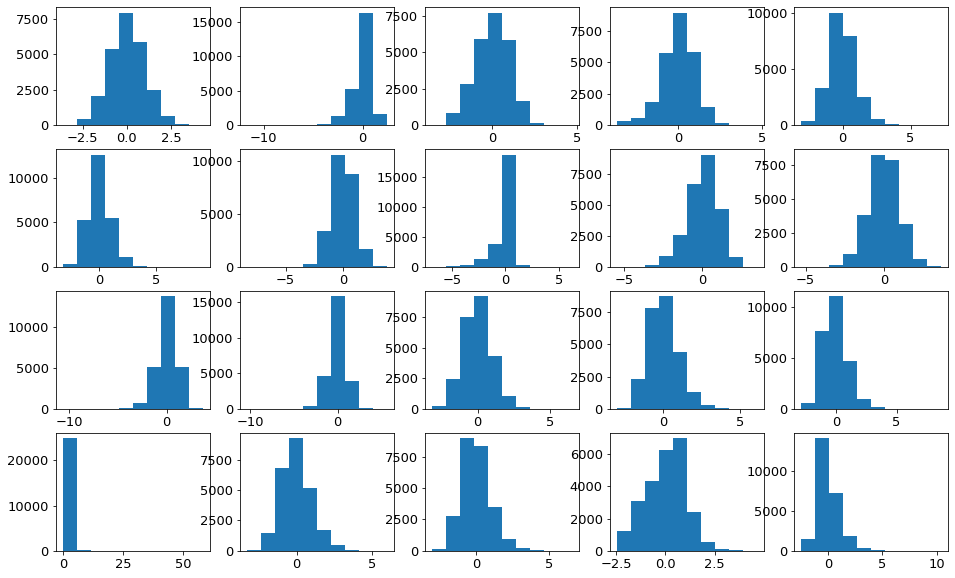

In [82]:
fig = plt.figure(figsize=(16,10)) 
fig_dims = (4, 5)
plt.subplot2grid(fig_dims, (0, 0))
plt.hist(X_sel[:,0])
plt.subplot2grid(fig_dims, (0, 1))
plt.hist(X_sel[:,1])
plt.subplot2grid(fig_dims, (0, 2))
plt.hist(X_sel[:,2])
plt.subplot2grid(fig_dims, (0, 3))
plt.hist(X_sel[:,3])
plt.subplot2grid(fig_dims, (0, 4))
plt.hist(X_sel[:,4])
plt.subplot2grid(fig_dims, (1, 0))
plt.hist(X_sel[:,5])
plt.subplot2grid(fig_dims, (1, 1))
plt.hist(X_sel[:,6])
plt.subplot2grid(fig_dims, (1, 2))
plt.hist(X_sel[:,7])
plt.subplot2grid(fig_dims, (1, 3))
plt.hist(X_sel[:,8])
plt.subplot2grid(fig_dims, (1, 4))
plt.hist(X_sel[:,9])
plt.subplot2grid(fig_dims, (2, 0))
plt.hist(X_sel[:,10])
plt.subplot2grid(fig_dims, (2, 1))
plt.hist(X_sel[:,11])
plt.subplot2grid(fig_dims, (2, 2))
plt.hist(X_sel[:,12])
plt.subplot2grid(fig_dims, (2, 3))
plt.hist(X_sel[:,13])
plt.subplot2grid(fig_dims, (2, 4))
plt.hist(X_sel[:,14])
plt.subplot2grid(fig_dims, (3, 0))
plt.hist(X_sel[:,15])
plt.subplot2grid(fig_dims, (3, 1))
plt.hist(X_sel[:,16])
plt.subplot2grid(fig_dims, (3, 2))
plt.hist(X_sel[:,17])
plt.subplot2grid(fig_dims, (3, 3))
plt.hist(X_sel[:,18])
plt.subplot2grid(fig_dims, (3, 4))
plt.hist(X_sel[:,19])



plt.show()

In [19]:
features_m[attributes_sel].describe()

feature      chroma_stft          mfcc                              \
statistics          mean           max                               
number                01            01            03            04   
count       25000.000000  25000.000000  25000.000000  25000.000000   
mean            0.462565    -20.651705     77.216744     97.423095   
std             0.125269     80.173710     30.280304     27.533432   
min             0.007378   -956.083374    -30.635883     -2.728852   
25%             0.379893    -55.762179     56.337381     82.351656   
50%             0.461643     -2.124669     78.743496     99.296551   
75%             0.544771     33.758356     98.887802    115.537561   
max             0.998968    179.631500    219.335754    226.823532   

feature                                                             \
statistics                                      mean           min   
number                07            11            02            02   
count       25000.000000  2.500000e+04  25000.000000  2.500000e+04   
mean           39.169007  3.263020e+01    145.467519 -1.380723e+01   
std            13.694475  1.026274e+01     31.895723  2.939209e+01   
min            -2.436376 -3.552714e-15   -120.390305 -2.158095e+02   
25%            30.221900  2.586619e+01    125.091242 -1.969505e+01   
50%            38.270540  3.164911e+01    146.314865 -5.861978e-14   
75%            47.057957  3.847342e+01    165.888699 -1.509903e-14   
max           138.707459  1.258175e+02    268.769104  1.697780e+02   

feature                                                             \
statistics                                                    skew   
number                04            05            11            04   
count       25000.000000  25000.000000  2.500000e+04  25000.000000   
mean          -44.038225    -57.100136 -3.689945e+01     -0.237731   
std            24.616465     19.273104  1.009017e+01      0.632943   
min          -178.541733   -158.575562 -1.443537e+02     -6.795655   
25%           -58.159300    -69.278635 -4.284797e+01     -0.593816   
50%           -42.024637    -56.664358 -3.594555e+01     -0.202934   
75%           -26.791640    -44.274807 -2.993456e+01      0.151003   
max            41.048645     13.535297  1.243450e-14      3.371832   

feature                                              spectral_bandwidth  \
statistics           std                                       kurtosis   
number                01            02            04                 01   
count       25000.000000  25000.000000  25000.000000       25000.000000   
mean           83.137375     37.225137     19.882866           6.757458   
std            23.585452     10.521918      5.968682          25.169901   
min             8.798236      5.100488      3.016758          -1.798091   
25%            67.112198     29.754039     15.649619          -0.117001   
50%            82.486855     36.413437     19.235301           1.211559   
75%            98.028921     43.480580     23.334822           4.898704   
max           236.649017    101.432625     71.776955        1469.540283   

feature    spectral_contrast                                   tonnetz  
statistics               max                         min           std  
number                    03            04            02            01  
count           25000.000000  25000.000000  25000.000000  25000.000000  
mean               42.870762     36.152628      3.083846      0.029862  
std                 4.905266      5.035435      1.247456      0.007603  
min                26.890791     20.860943      0.000000      0.010953  
25%                39.451633     32.675331      2.211205      0.024563  
50%                42.511370     35.696417      3.234507      0.028349  
75%                45.780018     39.115453      3.974912      0.033725  
max                72.327721     69.373383      8.855375      0.109266

## Boxplot

In [20]:
attributes_sel[:3]

MultiIndex([('chroma_stft', 'mean', '01'),
            (       'mfcc',  'max', '01'),
            (       'mfcc',  'max', '03')],
           names=['feature', 'statistics', 'number'])

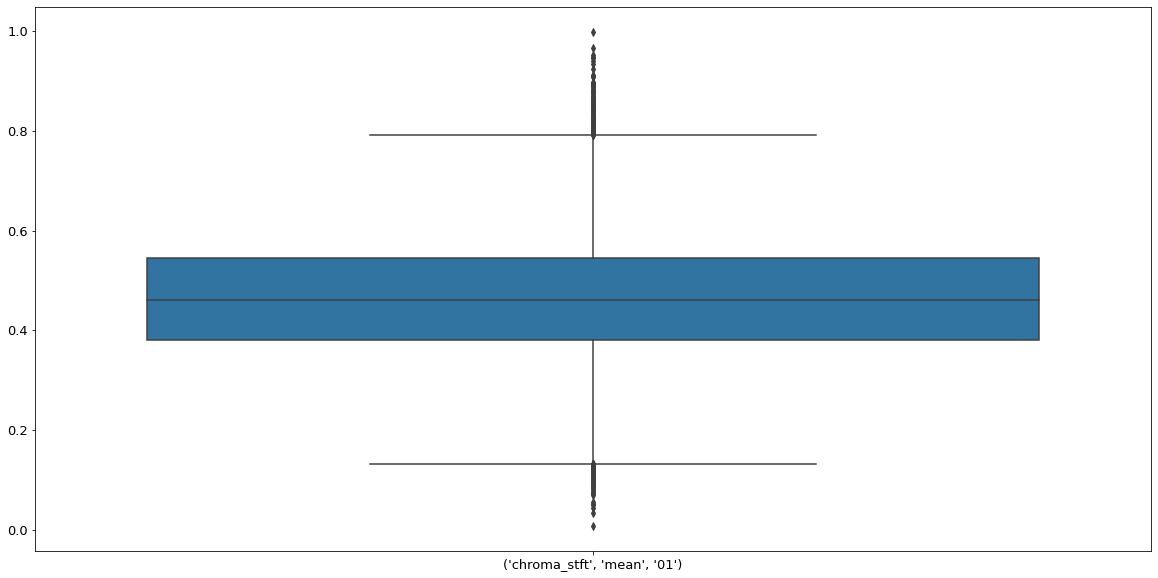

In [21]:
sns.boxplot(data= [X_sel[:,0]])
plt.xticks([0],[attributes_sel[0]])
plt.show()

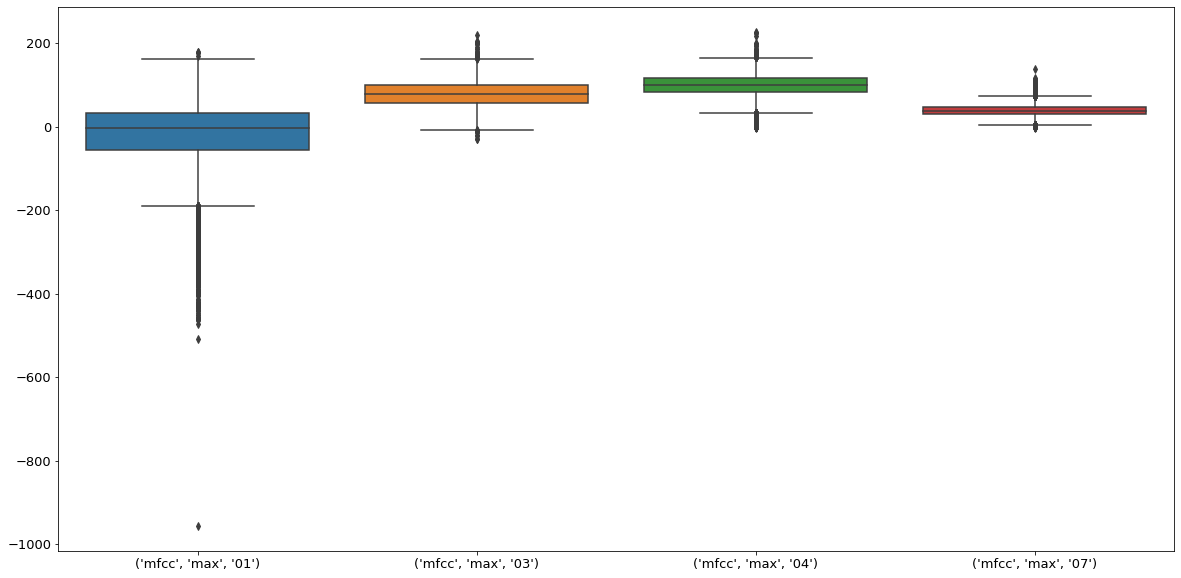

In [22]:
sns.boxplot(data= X_sel[:,1:5])
plt.xticks([0,1,2,3], attributes_sel[1:5])
plt.show()

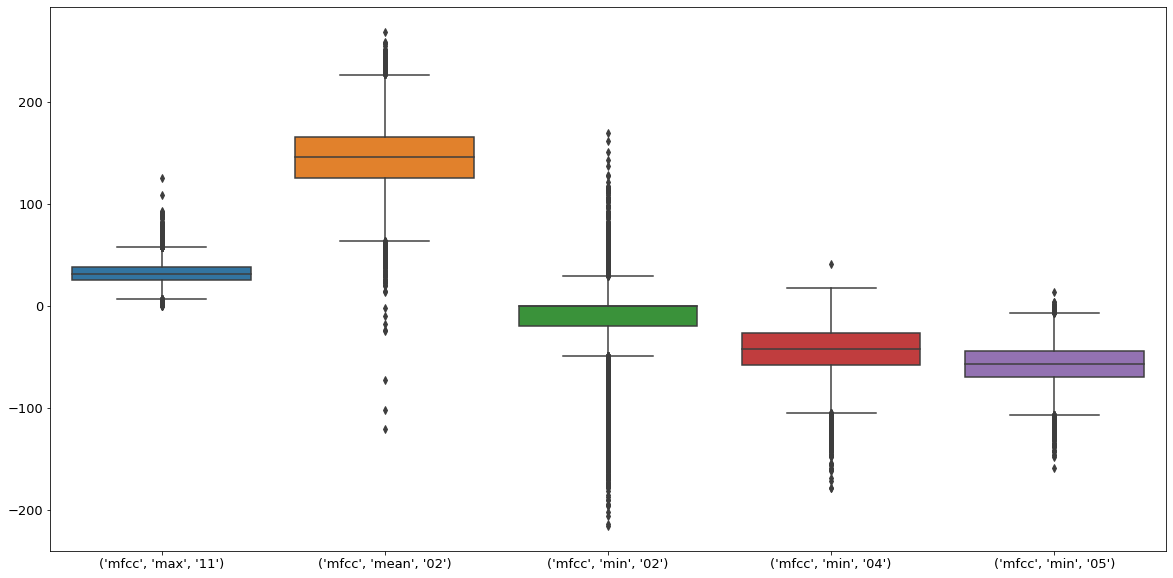

In [23]:
sns.boxplot(data= X_sel[:,5:10])
plt.xticks([0,1,2,3,4], attributes_sel[5:10])
plt.show()

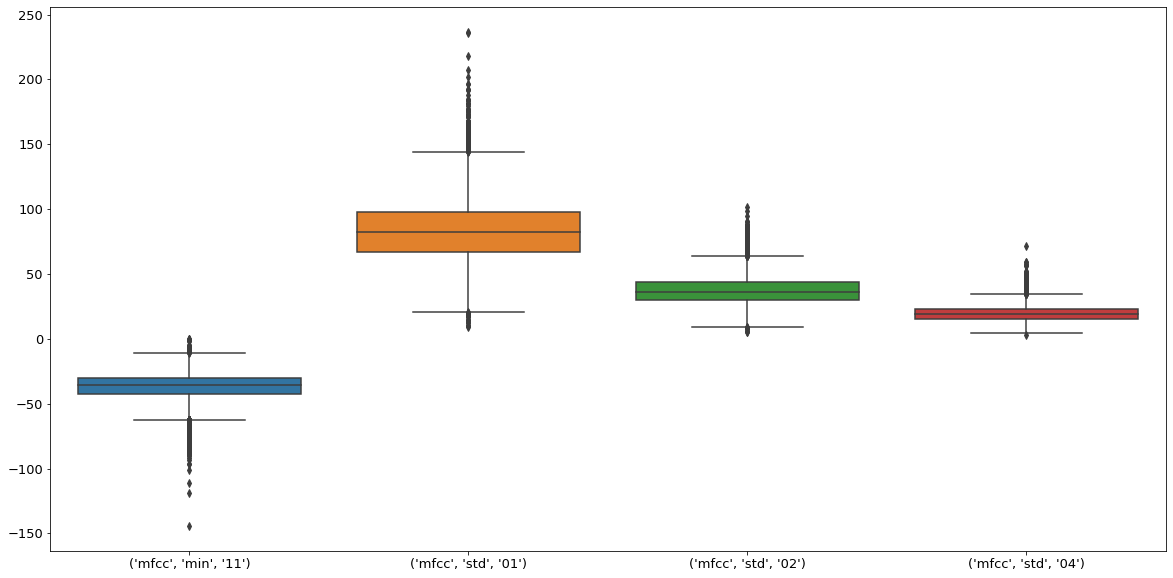

In [24]:
sns.boxplot(data= [X_sel[:,10],X_sel[:,12],X_sel[:,13],X_sel[:,14]])
plt.xticks([0,1,2,3], [attributes_sel[10],attributes_sel[12],attributes_sel[13],attributes_sel[14]])
plt.show()

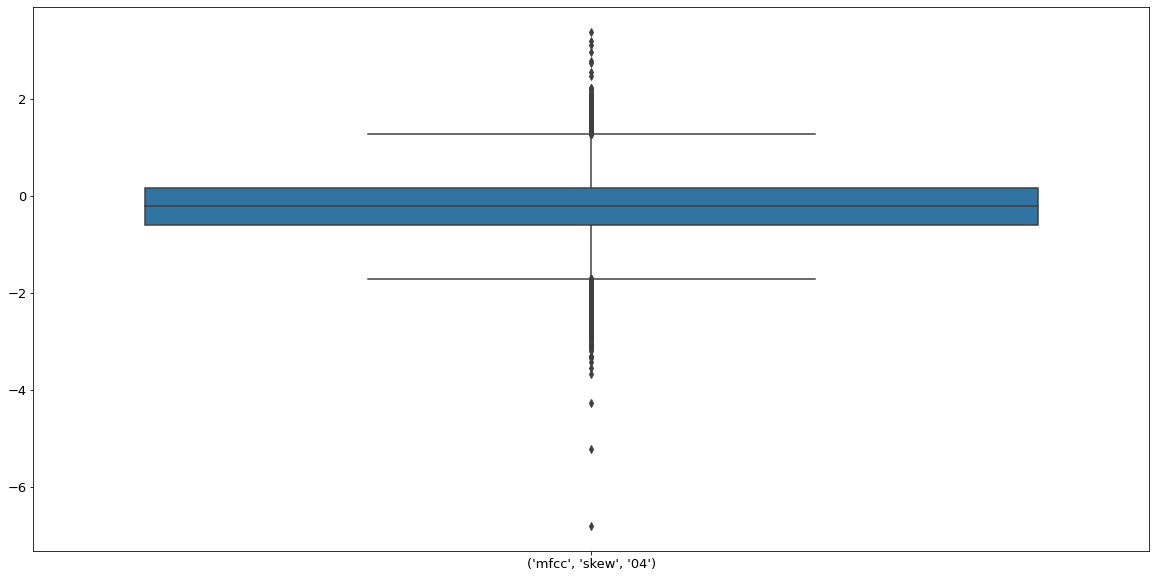

In [25]:
sns.boxplot(data= [X_sel[:,11]])
plt.xticks([0],[attributes_sel[11]])
plt.show()

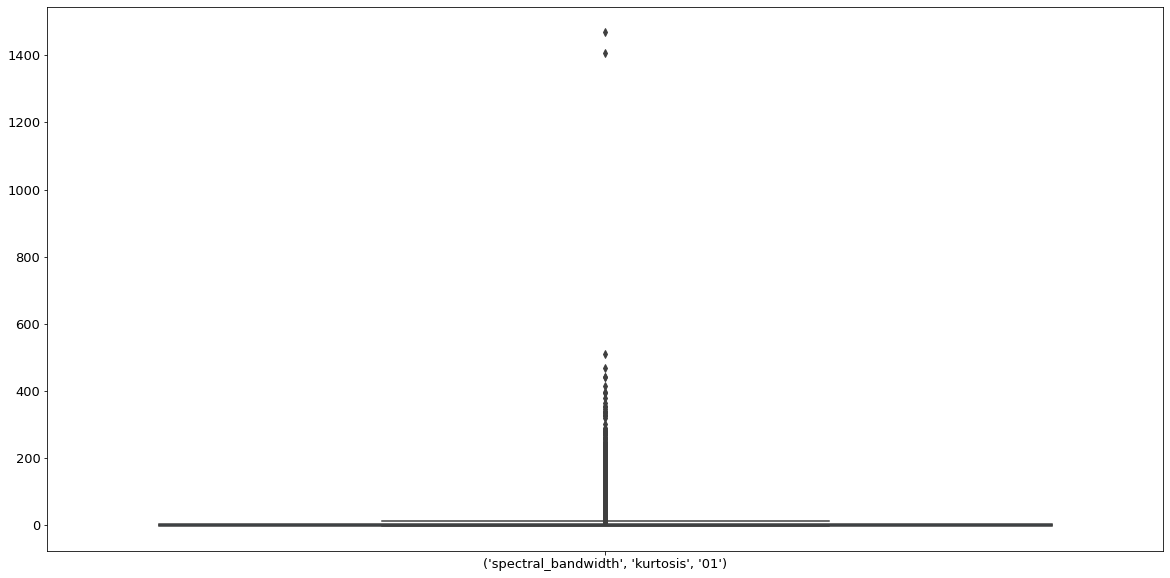

In [26]:
sns.boxplot(data= [X_sel[:,15]])
plt.xticks([0],[attributes_sel[15]])
plt.show()

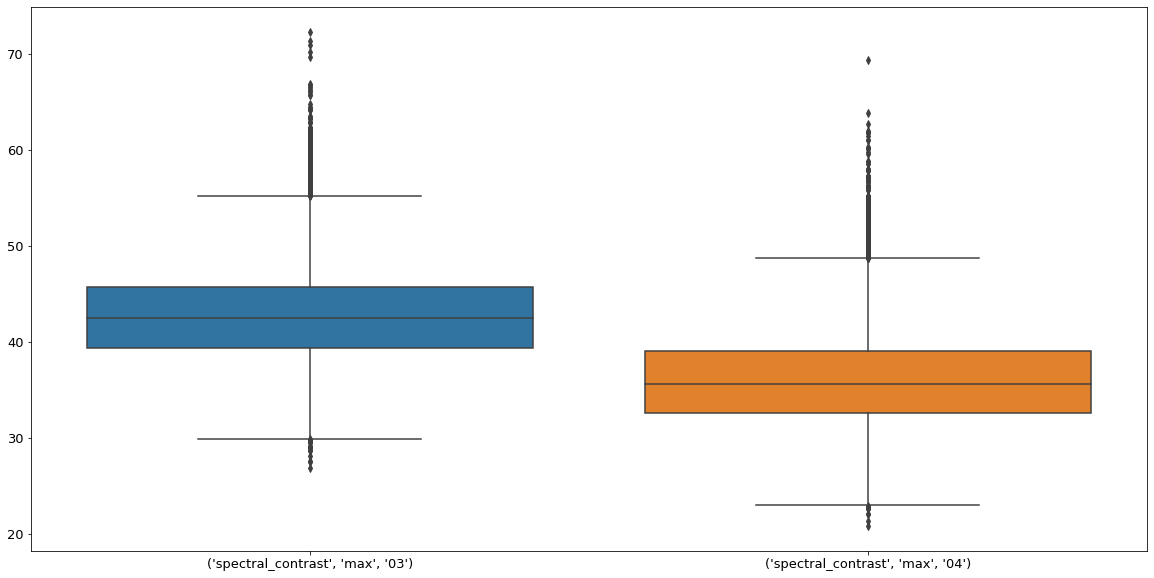

In [27]:
sns.boxplot(data= X_sel[:,16:18])
plt.xticks([0,1], attributes_sel[16:18])
plt.show()

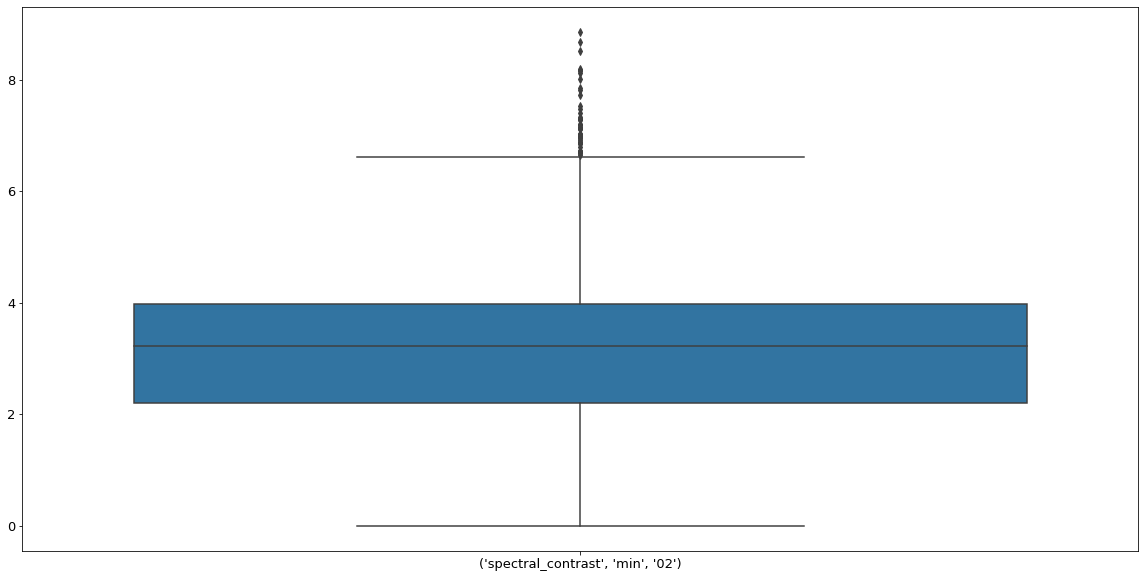

In [28]:
sns.boxplot(data= [X_sel[:,18]])
plt.xticks([0],[attributes_sel[18]])
plt.show()

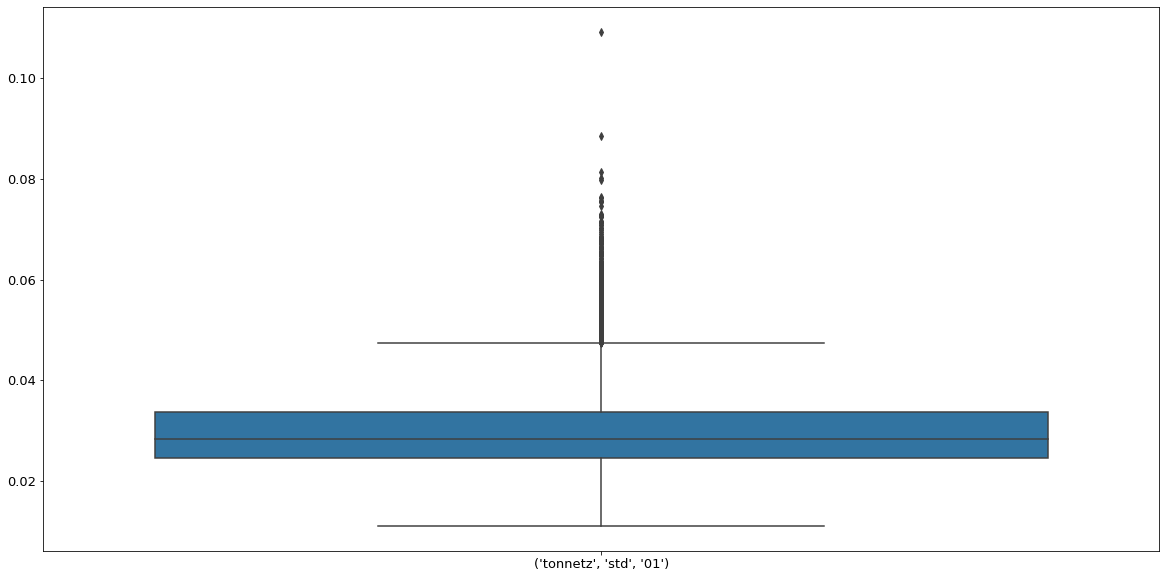

In [29]:
sns.boxplot(data= [X_sel[:,19]])
plt.xticks([0],[attributes_sel[19]])
plt.show()

In [46]:
Q1 = features_m[attributes_sel].quantile(0.25)
Q3 = features_m[attributes_sel].quantile(0.75)
IQR = Q3 - Q1

In [54]:
((features_m[attributes_sel] < (Q1 - 1.5 * IQR)) | (features_m[attributes_sel] > (Q3 + 1.5 * IQR))).sum()

feature             statistics  number
chroma_stft         mean        01         236
mfcc                max         01        1093
                                03          49
                                04         685
                                07         517
                                11         549
                    mean        02         317
                    min         02        3205
                                04         467
                                05         352
                                11         417
                    skew        04         700
                    std         01         239
                                02         372
                                04         431
spectral_bandwidth  kurtosis    01        3000
spectral_contrast   max         03         405
                                04         441
                    min         02          48
tonnetz             std         01         710
dtype: int64

## DBScan

In [48]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform

In [50]:
dist = pdist(X_sel, 'cityblock')
dist = squareform(dist)

In [51]:
k = 250
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

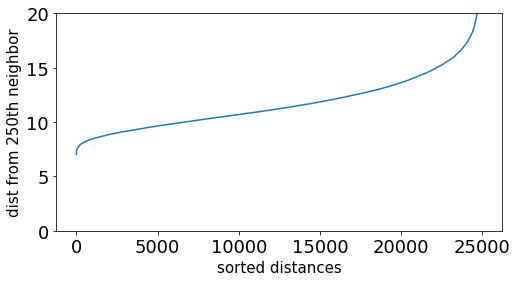

In [52]:
plt.figure(figsize=(8,4))
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=15)
plt.ylim(0,20)
plt.xlabel('sorted distances', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

In [53]:
dbscan = DBSCAN(eps=20, min_samples=200, metric='cityblock')

In [54]:
dbscan.fit(X_sel)

DBSCAN(eps=20, metric='cityblock', min_samples=200)

In [55]:
silhouette_score(X_sel, dbscan.labels_)

0.6904702314477097

In [56]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0], dtype=int64), array([   15, 24985], dtype=int64))

In [57]:
# Non lavora bene con dataset con alta dimensione

In [28]:
from sklearn.decomposition import PCA

In [59]:
pca = PCA(n_components=2)
pca.fit(X_sel)
X_sel_pca = pca.transform(X_sel)

In [2]:
plt.scatter(X_sel_pca[:, 0], X_sel_pca[:, 1], c=dbscan.labels_, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

NameError: name 'plt' is not defined

In [61]:
outlier = np.where(dbscan.labels_==-1)
outlier

(array([  489,   493,  1374,  4148,  5540,  6782,  8305,  9797, 12749,
        12751, 12752, 15454, 16643, 22484, 22971], dtype=int64),)

In [62]:
le.inverse_transform(features_m['genre'].iloc[[  489,   493,  1374,  4148,  5540,  6782,  8305,  9797, 12749,
        12751, 12752, 15454, 16643, 22484, 22971]])

array(['Electronic', 'Electronic', 'Experimental', 'International',
       'Experimental', 'Experimental', 'Experimental', 'Rock',
       'Experimental', 'Experimental', 'Experimental', 'Experimental',
       'Instrumental', 'Experimental', 'Experimental'], dtype=object)

In [63]:
tracks['track','genre_top'].value_counts()

Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3552
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: (track, genre_top), dtype: int64

## LOF

In [20]:
from sklearn.neighbors import LocalOutlierFactor

In [21]:
clf = LocalOutlierFactor(n_neighbors=20, metric='cityblock', contamination=0.01)

In [22]:
outliers = clf.fit_predict(X_sel)

In [23]:
clf.negative_outlier_factor_

array([-1.17847992, -1.10750717, -1.07685555, ..., -1.10286772,
       -1.10203552, -1.04456128])

In [24]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  250, 24750], dtype=int64))

In [25]:
outliers_genre =le.inverse_transform(features_m['genre'].iloc[np.where(outliers==-1)])

In [26]:
unique, counts = np.unique(outliers_genre, return_counts=True)
dict(zip(unique, counts))

{'Electronic': 60,
 'Experimental': 109,
 'Folk': 7,
 'Hip-Hop': 11,
 'Instrumental': 16,
 'International': 6,
 'Jazz': 1,
 'Old-Time / Historic': 1,
 'Pop': 6,
 'Rock': 29,
 'Spoken': 4}

In [29]:
pca = PCA(n_components=2)
pca.fit(X_sel)
X_sel_pca = pca.transform(X_sel)

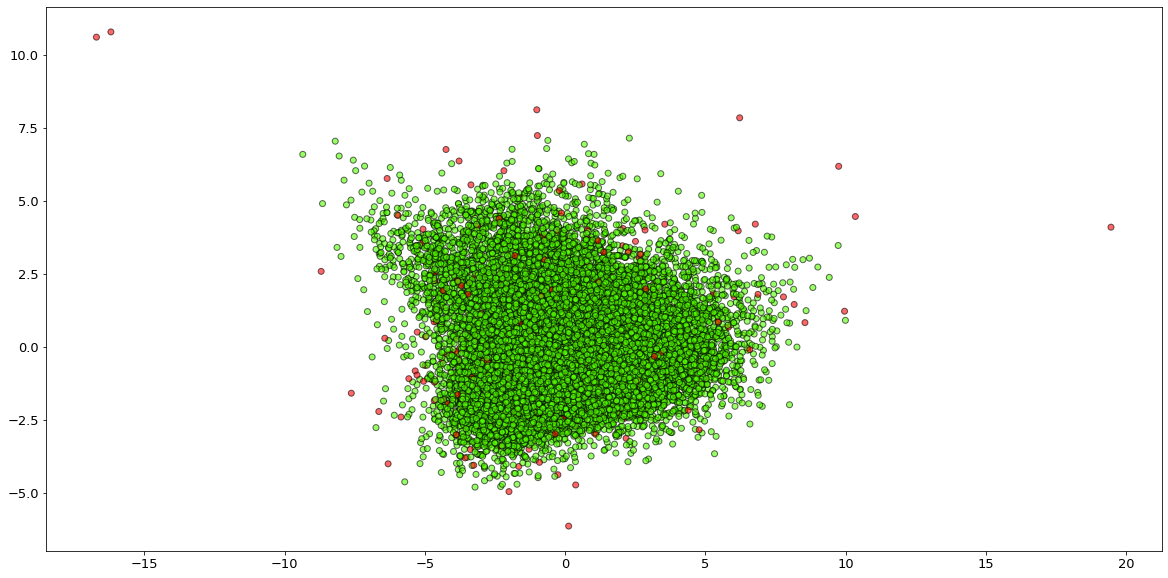

In [30]:
plt.scatter(X_sel_pca[:, 0], X_sel_pca[:, 1], c=outliers, cmap=plt.cm.prism, edgecolor='k', alpha=0.6)
plt.show()

In [31]:
features_m[attributes_sel].iloc[np.where(outliers==-1)]

feature    chroma_stft        mfcc                                     \
statistics        mean         max                                      
number              01          01          03          04         07   
track_id                                                                
718           0.287121 -106.054230   48.772358   98.452843  10.348667   
878           0.544615   -8.505424   68.230911   96.502800  53.126331   
1734          0.536058  -49.577049    8.671219   28.175589  57.984089   
3446          0.757819 -146.307007   44.959358  110.686043  27.013662   
3558          0.131156 -162.849350  125.224922   75.951286  95.172729   
...                ...         ...         ...         ...        ...   
143043        0.325615  139.429565   86.299004   99.853691  31.299086   
145706        0.447134   33.802948   22.523388  157.638519  81.360489   
145801        0.272221  -37.640980  117.457680  171.526047  50.239986   
147920        0.382601   31.046919  142.682983   89.653923  41.139973   
154295        0.583811  -31.621655   68.296326  127.335358  61.525814   

feature                                                                  \
statistics                   mean           min                           
number             11          02            02          04          05   
track_id                                                                  
718          7.642760   94.161911 -5.506706e-14  -13.637805  -82.076996   
878         23.667244  156.252197 -4.618528e-14  -96.994423  -53.622879   
1734        16.245735   95.965698  1.017109e+00  -22.845928  -13.813553   
3446        25.624411  185.574066 -1.953993e-14  -79.208275  -61.060467   
3558        79.346901  167.898239 -6.394885e-14 -114.663841  -98.477394   
...               ...         ...           ...         ...         ...   
143043      53.657631   84.950218 -7.924821e+01  -69.189644  -97.578560   
145706      33.262989  144.588715 -1.004853e+02  -40.430687  -97.640053   
145801      22.689219   80.987305 -7.077014e+01  -32.255074  -51.742737   
147920      50.151070  128.186188 -3.434995e+00 -105.111267 -135.133713   
154295      35.171997  113.671570 -3.552714e-15  -83.212822 -126.119659   

feature                                                            \
statistics                 skew         std                         
number             11        04          01         02         04   
track_id                                                            
718        -44.254951 -0.675858  123.283829  39.802498  20.139915   
878        -33.088131 -2.703493  115.798607  66.311684  21.374149   
1734       -23.276087  0.062402   45.385750  21.688393   7.539952   
3446       -34.106224  1.373527   37.236279  33.272614  25.257160   
3558       -39.370636 -0.475623   80.864853  72.889923  31.008293   
...               ...       ...         ...        ...        ...   
143043     -35.175175 -0.623401  157.735687  80.420502  25.265097   
145706     -39.049900  0.648479   72.814972  38.389782  23.357582   
145801     -57.414993  0.139435  105.568436  40.286686  41.282120   
147920     -51.477791  0.146948   81.659790  36.378780  16.028177   
154295     -36.663307  1.007005   92.701004  43.564754  42.211010   

feature    spectral_bandwidth spectral_contrast                        tonnetz  
statistics           kurtosis               max                  min       std  
number                     01                03         04        02        01  
track_id                                                                        
718                  7.362855         40.073883  26.185898  4.271856  0.034536  
878                 11.660445         53.660362  55.051353  3.404290  0.027870  
1734               152.408035         34.407272  35.632790  3.638713  0.018979  
3446                 3.240825         39.230389  34.175877  5.424079  0.023856  
3558                53.366112         62.008945  63.851372  0.116964  0.046830  
...          

## Isolation Forest

In [19]:
from sklearn.ensemble import IsolationForest

In [20]:
clf = IsolationForest(random_state=0, contamination=0.01)

In [21]:
outliers = clf.fit_predict(X_sel)

In [22]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  250, 24750], dtype=int64))

In [23]:
np.where(outliers==-1)

(array([  193,   229,   371,   489,   493,  1096,  1176,  1374,  1430,
         1433,  1468,  1471,  1573,  1680,  2099,  2706,  2745,  2753,
         2757,  2760,  2765,  2767,  2768,  2769,  2770,  2775,  2777,
         2784,  2792,  2814,  2815,  2821,  2967,  3065,  3068,  3070,
         3072,  3074,  3079,  3081,  3083,  3084,  3092,  3094,  3096,
         3097,  3098,  3102,  3103,  3104,  3105,  3106,  3184,  3192,
         3314,  3320,  3322,  3327,  3333,  3336,  3339,  3340,  3342,
         3343,  3344,  3456,  3457,  3460,  3462,  3463,  3469,  3479,
         3563,  3565,  3606,  3608,  3609,  3648,  3802,  3803,  3884,
         3943,  4120,  4121,  4123,  4124,  4125,  4126,  4127,  4131,
         4145,  4147,  4148,  4149,  4150,  4152,  4203,  4209,  4252,
         4254,  4278,  4284,  4285,  4286,  4287,  4288,  4289,  4327,
         4499,  4740,  5044,  5434,  5540,  5670,  5675,  5691,  5847,
         5850,  5894,  5897,  6100,  6246,  6299,  6408,  6519,  6778,
      

In [25]:
outliers_genre =le.inverse_transform(features_m['genre'].iloc[np.where(outliers==-1)])

In [26]:
unique, counts = np.unique(outliers_genre, return_counts=True)
dict(zip(unique, counts))

{'Classical': 2,
 'Electronic': 62,
 'Experimental': 59,
 'Folk': 1,
 'Hip-Hop': 3,
 'Instrumental': 11,
 'International': 17,
 'Old-Time / Historic': 87,
 'Pop': 1,
 'Rock': 6,
 'Spoken': 1}

In [29]:
pca = PCA(n_components=2)
pca.fit(X_sel)
X_sel_pca = pca.transform(X_sel)

In [33]:
outliers==1

array([ True,  True,  True, ...,  True,  True,  True])

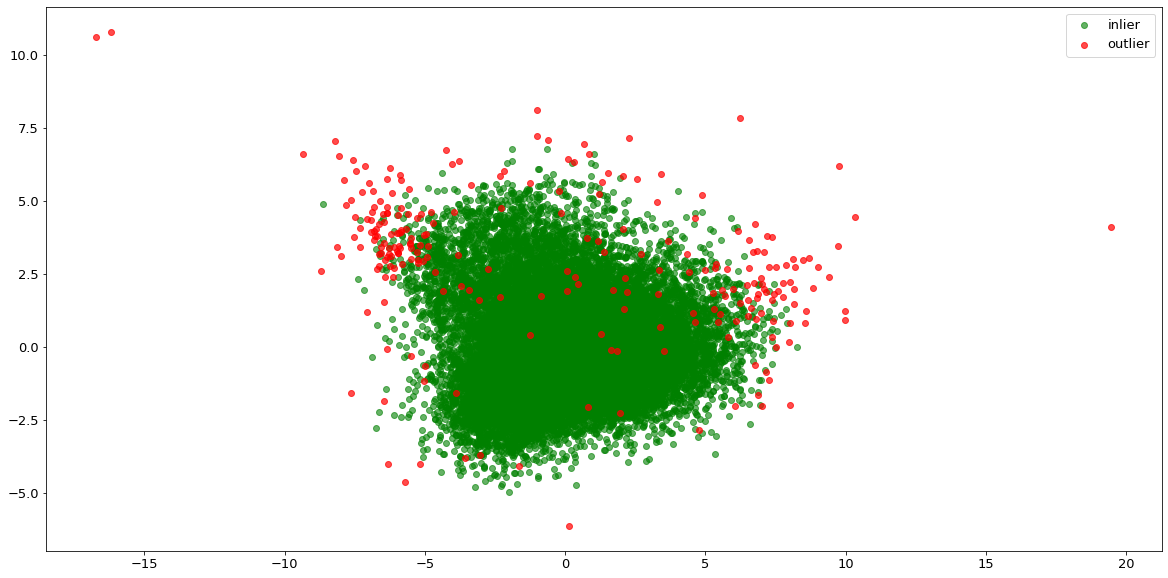

In [52]:
plt.scatter(X_sel_pca[outliers==1][:, 0], X_sel_pca[outliers==1][:, 1], c='g',label='inlier', alpha=0.6)
plt.scatter(X_sel_pca[outliers==-1][:, 0], X_sel_pca[outliers==-1][:, 1], c='r', label='outlier', alpha=0.7)
plt.legend()
plt.show()

## ABOD

In [92]:
from pyod.models.abod import ABOD

In [93]:
clf = ABOD(contamination=0.01, n_neighbors=30)
clf.fit(X_sel)

ABOD(contamination=0.01, method='fast', n_neighbors=30)

In [94]:
outliers = clf.predict(X_sel)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([24752,   248], dtype=int64))

In [95]:
pca = PCA(n_components=2)
pca.fit(X_sel)
X_sel_pca = pca.transform(X_sel)

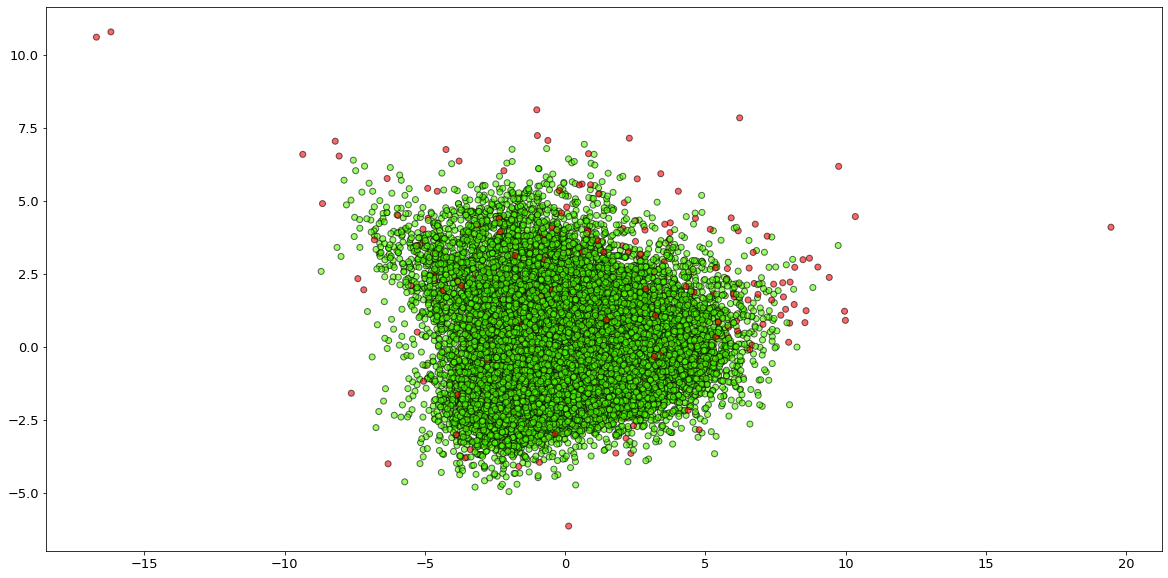

In [96]:
plt.scatter(X_sel_pca[:, 0], X_sel_pca[:, 1], c=outliers, cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.show()

In [97]:
le.classes_

array(['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic',
       'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International',
       'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken'],
      dtype=object)

In [98]:
le.transform(le.classes_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [99]:
dict(features_m['genre'].value_counts())

{13: 7103,
 4: 6314,
 5: 2251,
 7: 2201,
 6: 1519,
 8: 1350,
 12: 1186,
 9: 1018,
 1: 619,
 11: 510,
 10: 384,
 2: 178,
 14: 154,
 15: 118,
 0: 74,
 3: 21}

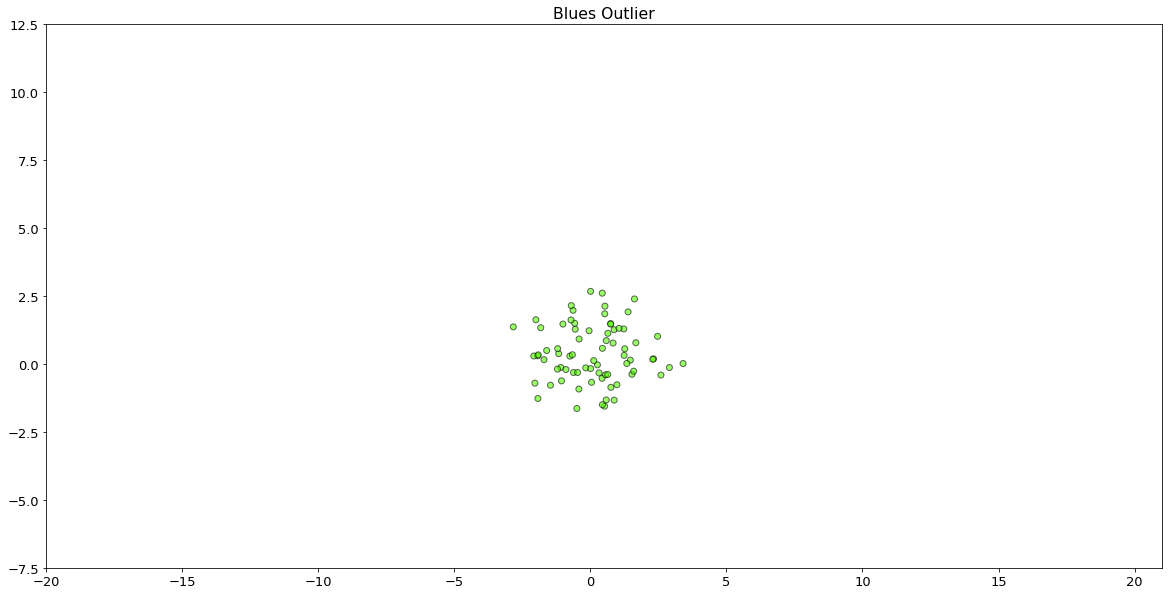

In [119]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==0], X_sel_pca[:,1][features_m['genre']==0], 
            c=outliers[features_m['genre']==0], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Blues Outlier')
plt.show()

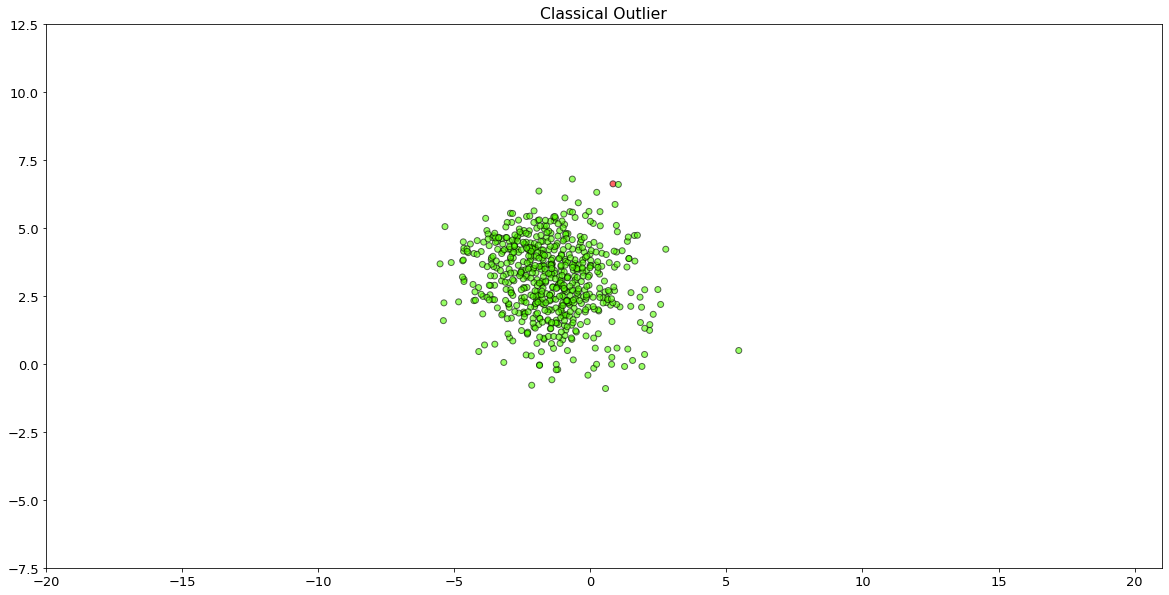

In [122]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==1], X_sel_pca[:,1][features_m['genre']==1], 
            c=outliers[features_m['genre']==1], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Classical Outlier')
plt.show()

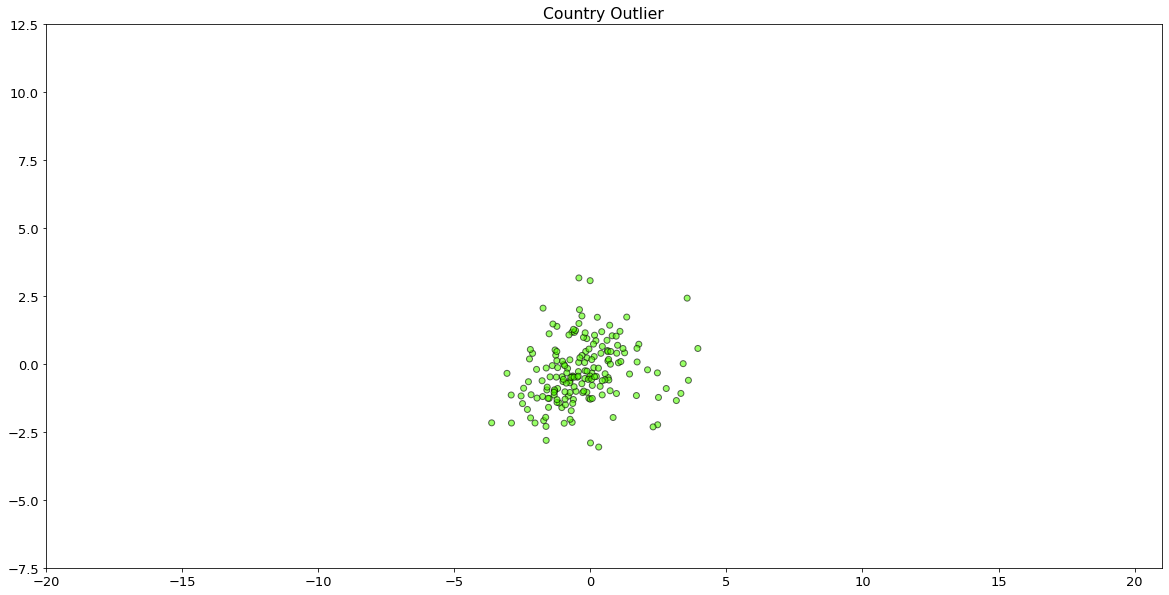

In [123]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==2], X_sel_pca[:,1][features_m['genre']==2], 
            c=outliers[features_m['genre']==2], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Country Outlier')
plt.show()

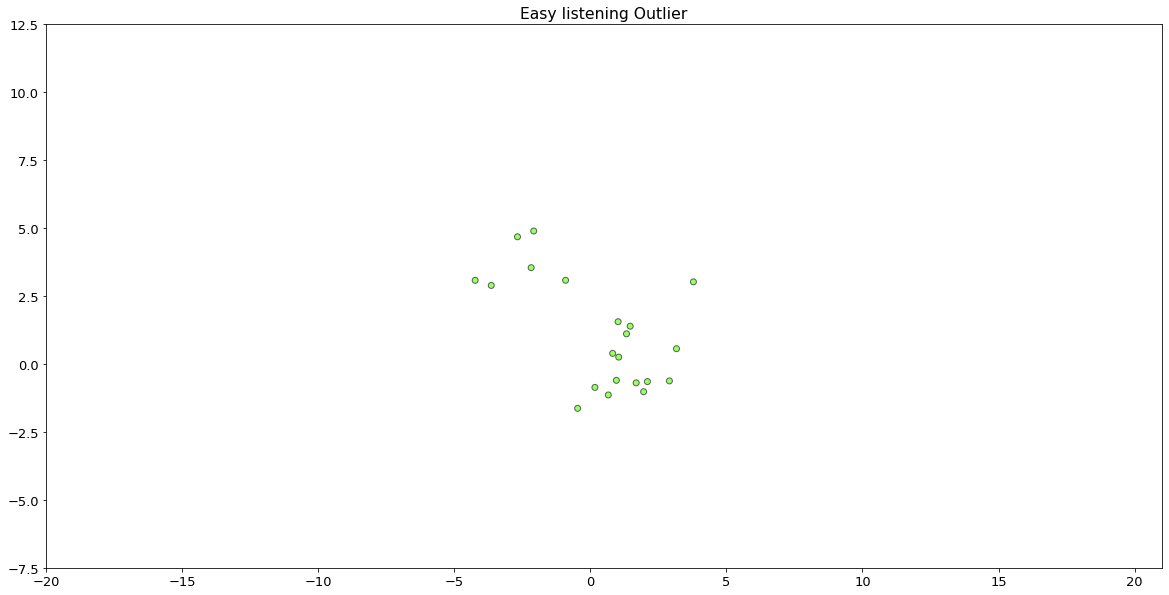

In [124]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==3], X_sel_pca[:,1][features_m['genre']==3], 
            c=outliers[features_m['genre']==3], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Easy listening Outlier')
plt.show()

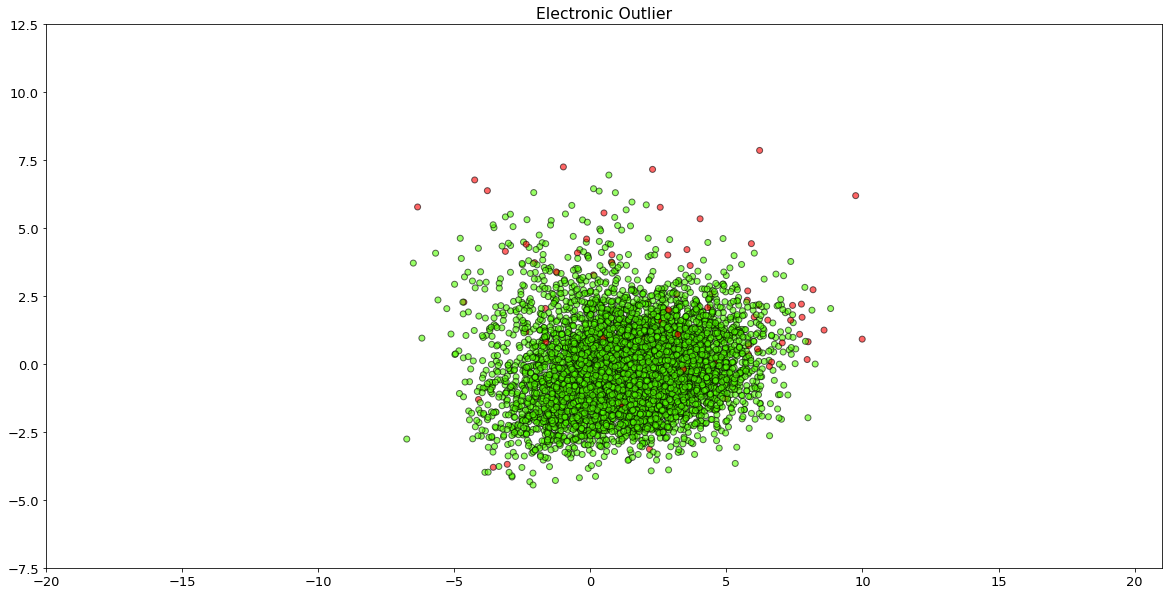

In [126]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==4], X_sel_pca[:,1][features_m['genre']==4], 
            c=outliers[features_m['genre']==4], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Electronic Outlier')
plt.show()

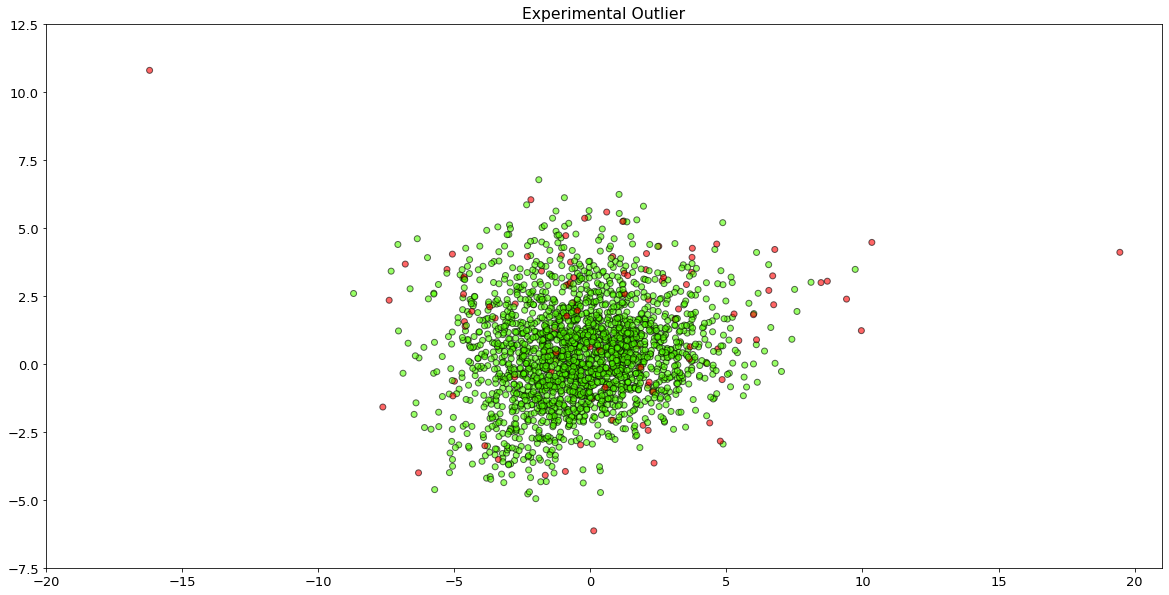

In [128]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==5], X_sel_pca[:,1][features_m['genre']==5], 
            c=outliers[features_m['genre']==5], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Experimental Outlier')
plt.show()

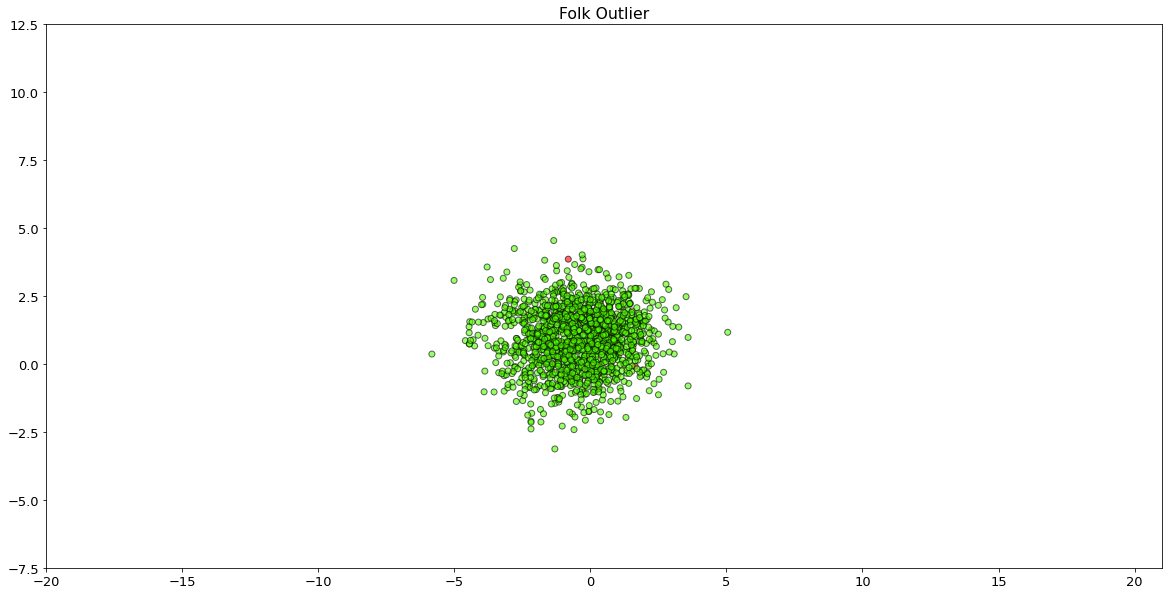

In [130]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==6], X_sel_pca[:,1][features_m['genre']==6], 
            c=outliers[features_m['genre']==6], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Folk Outlier')
plt.show()

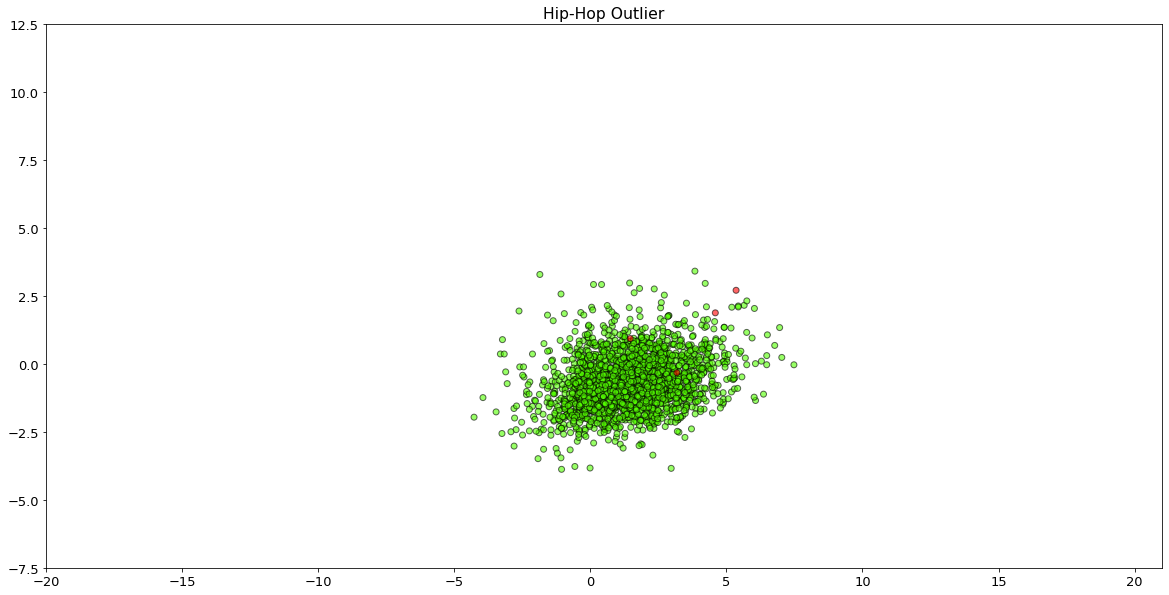

In [132]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==7], X_sel_pca[:,1][features_m['genre']==7], 
            c=outliers[features_m['genre']==7], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Hip-Hop Outlier')
plt.show()

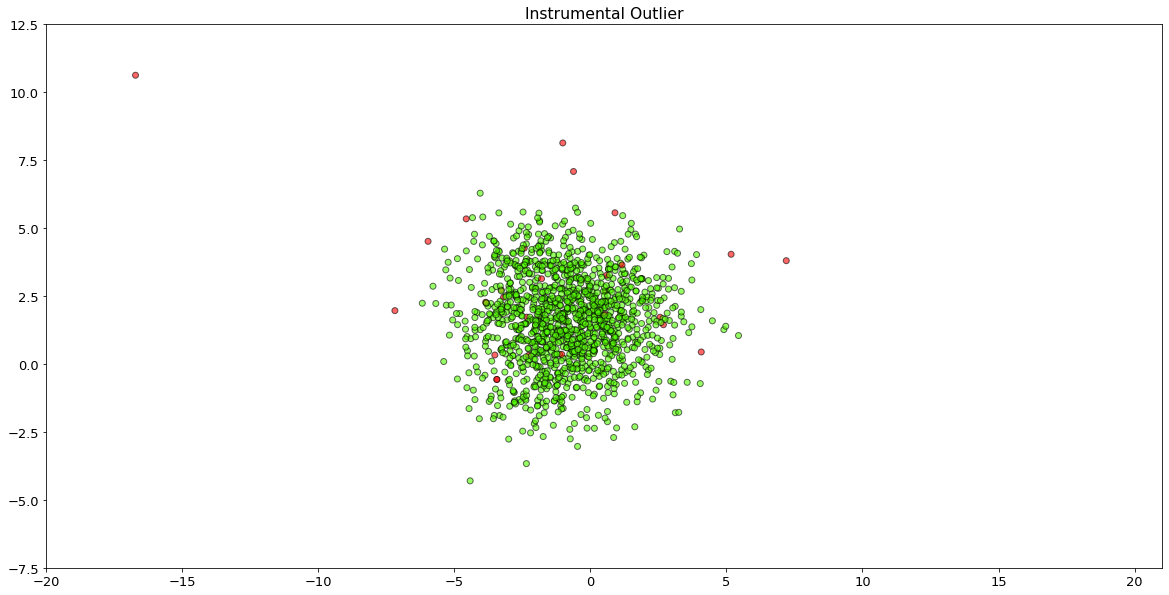

In [134]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==8], X_sel_pca[:,1][features_m['genre']==8], 
            c=outliers[features_m['genre']==8], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Instrumental Outlier')
plt.show()

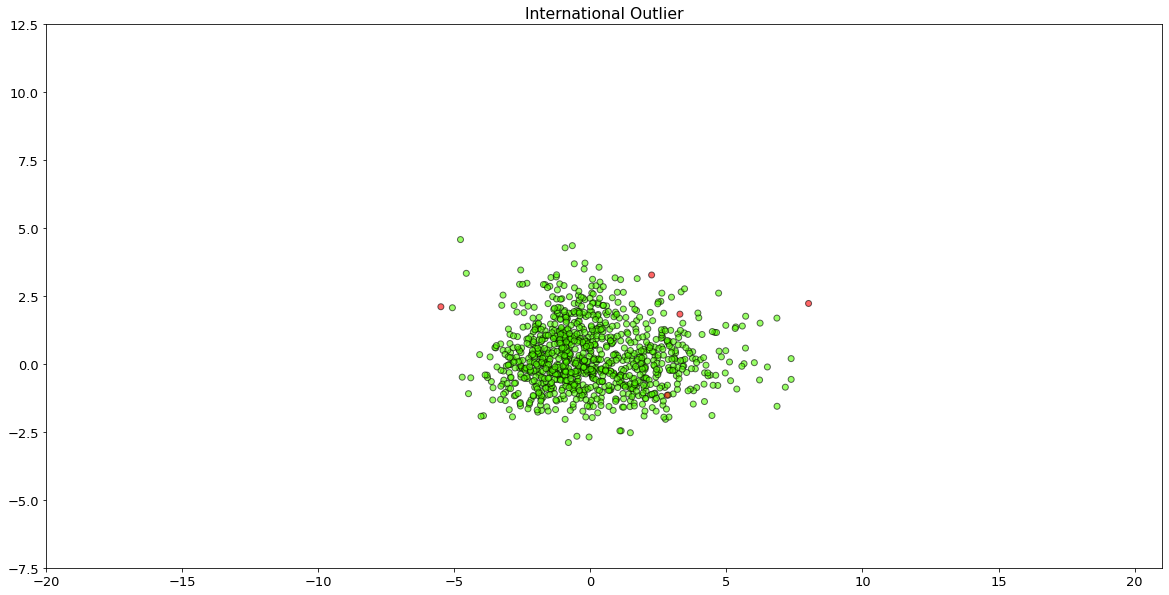

In [135]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==9], X_sel_pca[:,1][features_m['genre']==9], 
            c=outliers[features_m['genre']==9], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('International Outlier')
plt.show()

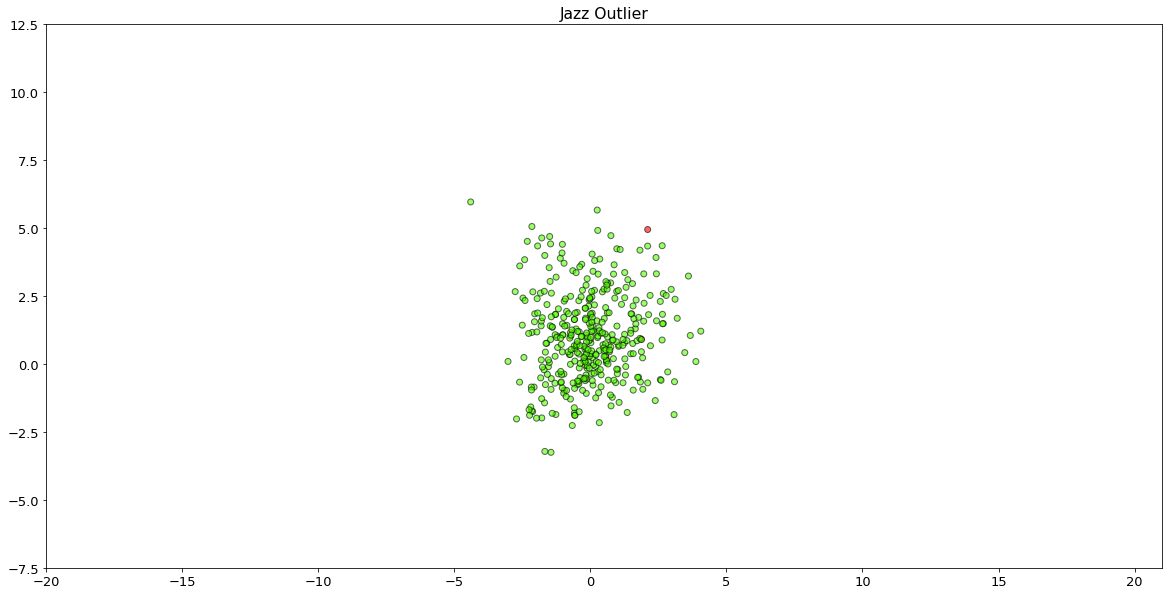

In [136]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==10], X_sel_pca[:,1][features_m['genre']==10], 
            c=outliers[features_m['genre']==10], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Jazz Outlier')
plt.show()

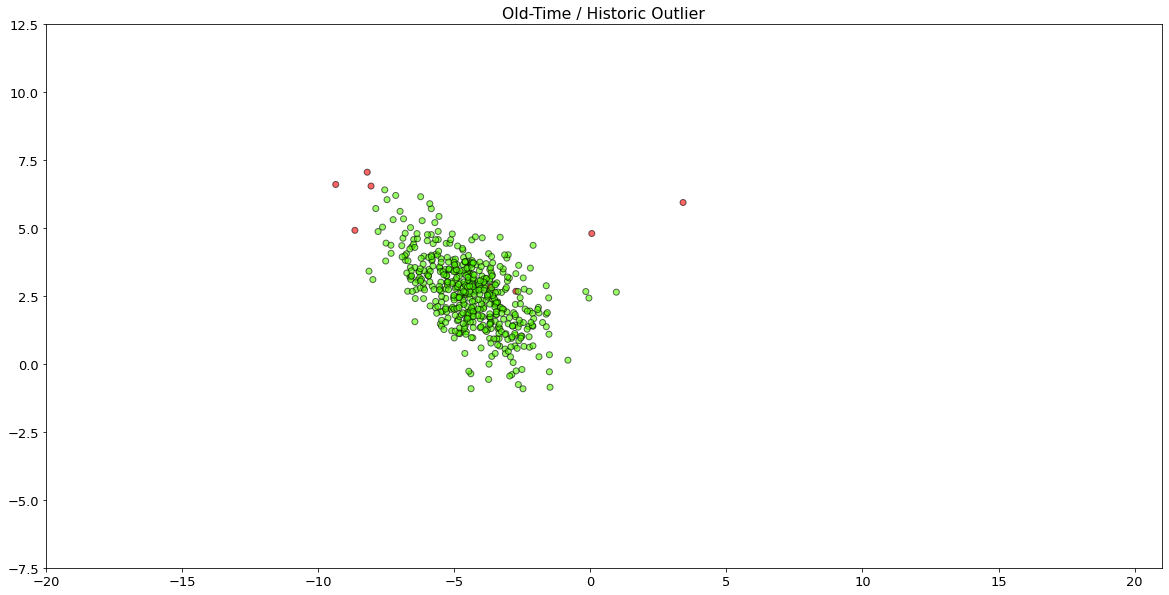

In [138]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==11], X_sel_pca[:,1][features_m['genre']==11], 
            c=outliers[features_m['genre']==11], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Old-Time / Historic Outlier')
plt.show()

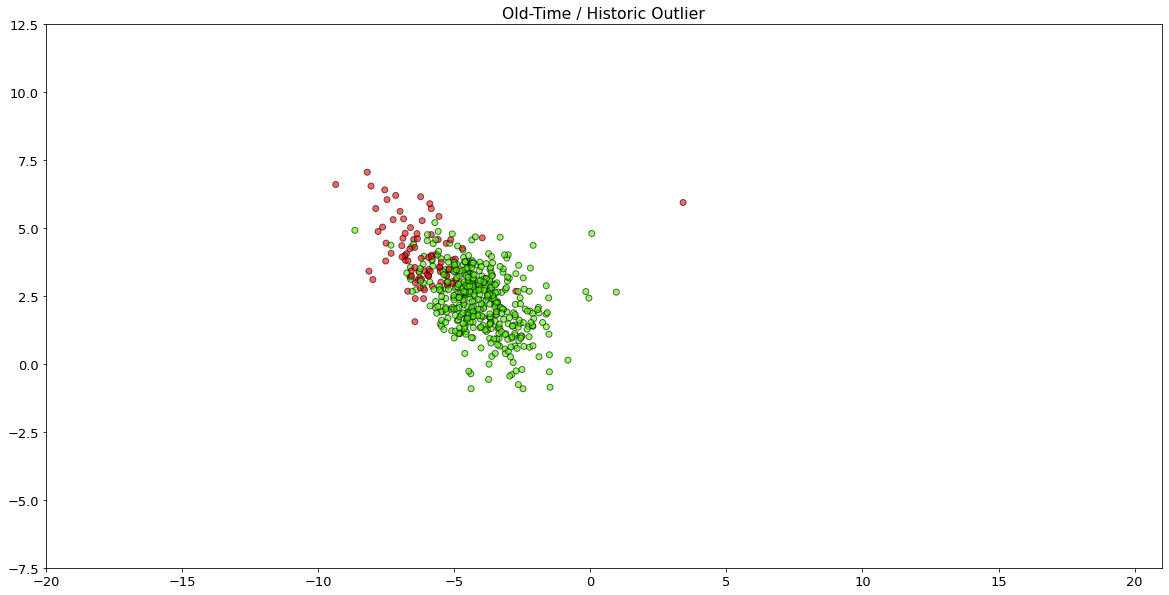

In [153]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==11], X_sel_pca[:,1][features_m['genre']==11], 
            c=outliers[features_m['genre']==11], cmap=plt.cm.prism, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Old-Time / Historic Outlier')
plt.show()

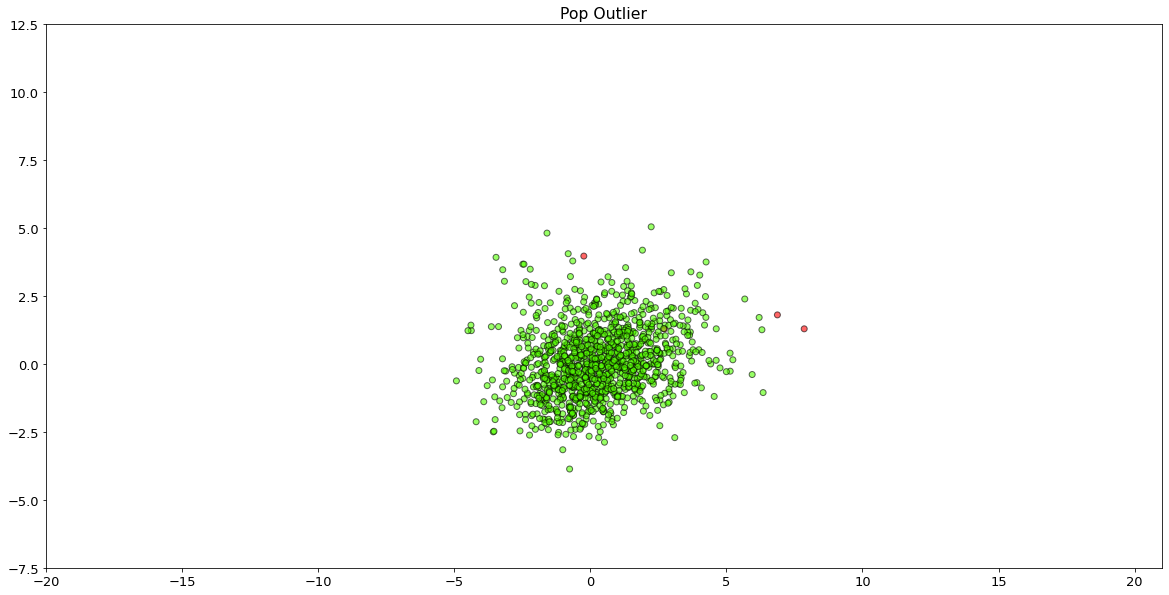

In [141]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==12], X_sel_pca[:,1][features_m['genre']==12], 
            c=outliers[features_m['genre']==12], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Pop Outlier')
plt.show()

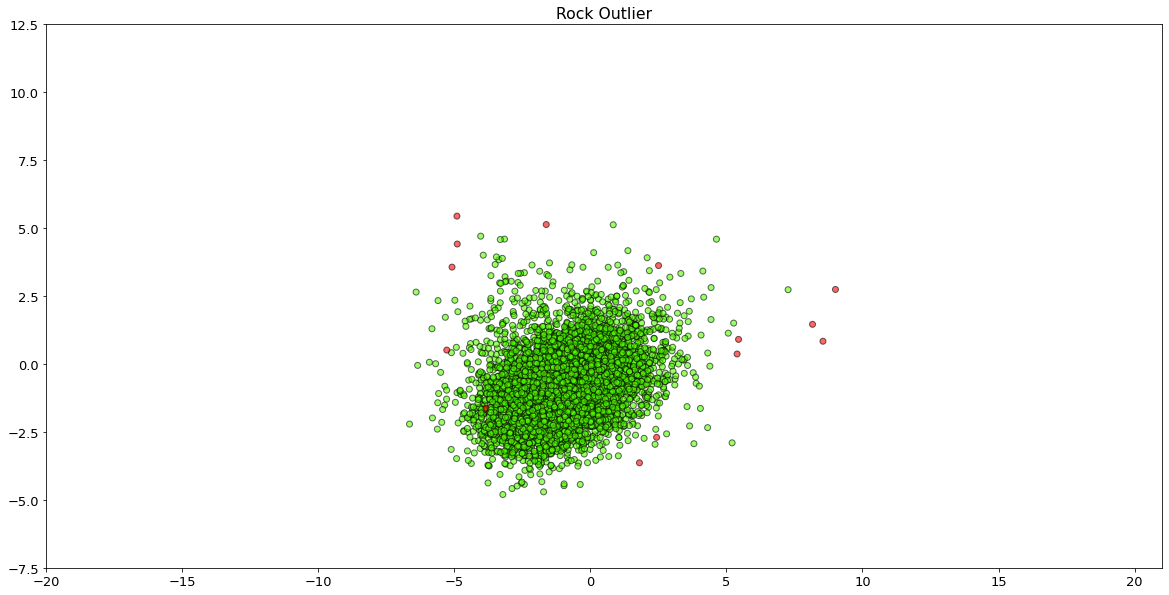

In [143]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==13], X_sel_pca[:,1][features_m['genre']==13], 
            c=outliers[features_m['genre']==13], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Rock Outlier')
plt.show()

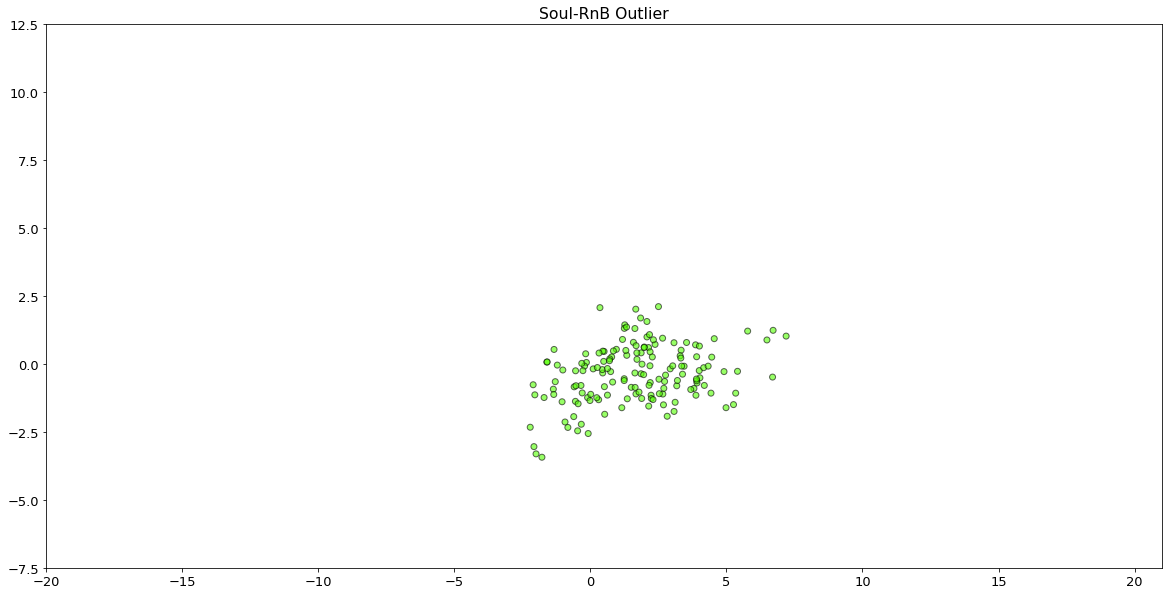

In [144]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==14], X_sel_pca[:,1][features_m['genre']==14], 
            c=outliers[features_m['genre']==14], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Soul-RnB Outlier')
plt.show()

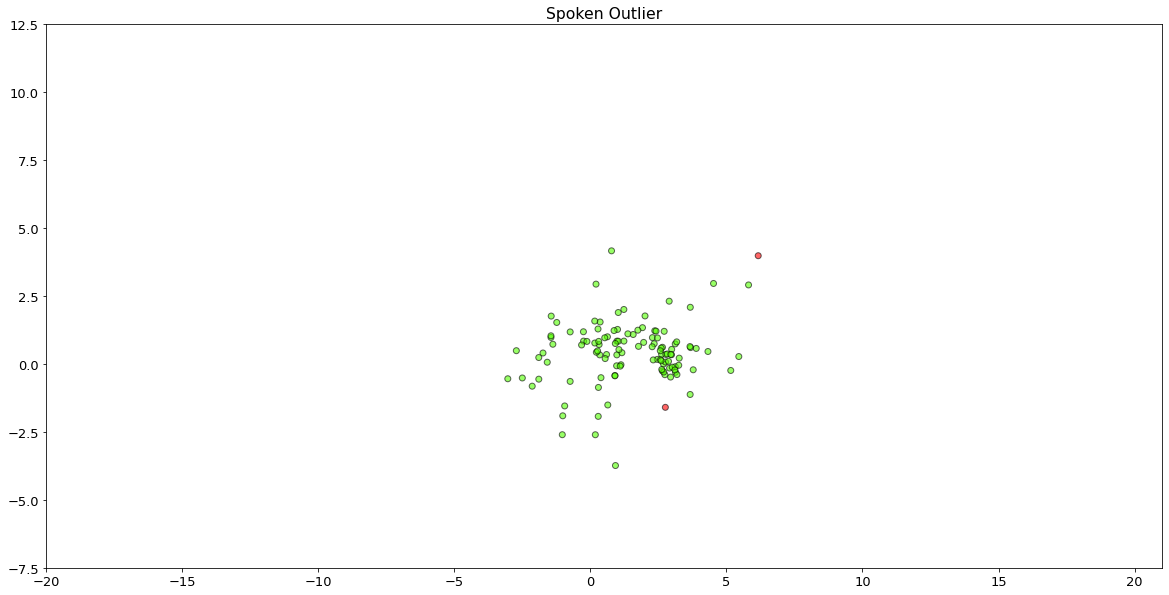

In [146]:
plt.scatter(X_sel_pca[:,0][features_m['genre']==15], X_sel_pca[:,1][features_m['genre']==15], 
            c=outliers[features_m['genre']==15], cmap=plt.cm.prism_r, edgecolor='k', alpha=0.6)
plt.ylim(-7.5, 12.5)
plt.xlim(-20, 21)
plt.title('Spoken Outlier')
plt.show()

In [117]:
outliers_genre =le.inverse_transform(features_m['genre'].iloc[np.where(outliers==1)])

In [118]:
unique, counts = np.unique(outliers_genre, return_counts=True)
dict(zip(unique, counts))

{'Classical': 1,
 'Electronic': 76,
 'Experimental': 98,
 'Folk': 3,
 'Hip-Hop': 4,
 'Instrumental': 27,
 'International': 5,
 'Jazz': 2,
 'Old-Time / Historic': 8,
 'Pop': 4,
 'Rock': 18,
 'Spoken': 2}

In [82]:
new_features_m=features_m[attributes_sel]

In [83]:
new_features_m[('class','genre','top')]=tracks['track','genre_top']

<ipython-input-83-1ee60e13ee14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_features_m[('class','genre','top')]=tracks['track','genre_top']


In [84]:
outliers==1

array([False, False, False, ..., False, False, False])

In [85]:
new_features_m = new_features_m[outliers==0]

In [86]:
new_features_m.to_csv('fma_metadata/new_features_m.csv', index=True)

In [87]:
df= utils.load('fma_metadata/new_features_m.csv')

In [88]:
df

feature    chroma_stft       mfcc                                    \
statistics        mean        max                                     
number              01         01         03          04         07   
track_id                                                              
2             0.696063  28.657707  52.424423  103.289833  37.843021   
3             0.449602  29.380682  76.742714  137.245010  55.662521   
5             0.481160 -40.500740  50.373932  112.312531  29.266182   
10            0.388109  20.196968  60.412815   78.466721  21.597277   
134           0.438062 -41.723225  58.687328  125.922821  37.450359   
...                ...        ...        ...         ...        ...   
155297        0.408626   3.826046  94.208336   48.085751  26.723190   
155298        0.439034 -72.790154  81.013275  124.569000  29.571426   
155306        0.369401  -7.814734  88.024063  116.180260  29.388819   
155307        0.357939 -13.889938  62.219879   93.028778  41.311356   
155314        0.551894 -15.305521  32.737503   95.054657  25.620636   

feature                                                                ...  \
statistics                   mean           min                        ...   
number             11          02            02         04         05  ...   
track_id                                                               ...   
2           27.737400  116.696678 -1.421085e-14 -51.569004 -97.879890  ...   
3           26.740063  120.158501 -1.851665e+01 -12.548506 -87.048355  ...   
5           27.197964  132.215073 -6.228398e+01 -24.319845 -74.060310  ...   
10          24.780317  157.040085  5.151435e-14 -50.578659 -45.113949  ...   
134         36.486378  125.521309 -9.427860e-01 -90.334747 -67.671829  ...   
...               ...         ...           ...        ...        ...  ...   
155297      19.866936  163.954620 -1.776357e-14 -29.221125 -28.104187  ...   
155298      38.472843  160.770218 -7.993606e-14  -7.314378 -69.236115  ...   
155306      47.185654  177.614151  5.329071e-15 -49.451691 -70.841232  ...   
155307      33.690544  124.228142 -5.892177e+00 -50.547176 -99.119080  ...   
155314      34.402496  166.692734 -2.464827e-01 -55.172737 -55.477066  ...   

feature                                                spectral_bandwidth  \
statistics      skew         std                                 kurtosis   
number            04          01         02         04                 01   
track_id                                                                    
2           0.043292   97.809044  38.569584  20.767921           3.874384   
3          -0.026875  111.686371  41.191982  22.025253           2.383340   
5          -0.108640   95.049904  39.367599  24.319347           0.895442   
10         -0.561734  102.743553  44.409843  14.013119           0.437628   
134        -0.479446  102.779747  47.266518  36.841534           0.372903   
...              ...         ...        ...        ...                ...   
155297      0.369148   91.869461  30.287067  12.060067          20.706787   
155298      0.602545   94.696381  39.359367  18.604885           5.868375   
155306      0.172813  109.087029  40.537926  28.671246           4.375974   
155307     -0.412079   80.234474  35.382370  22.123117          -0.383395   
155314     -1.755459   64.040298  26.786989  22.369673           0.011010   

feature    spectral_contrast                        tonnetz         class  
statistics               max                  min       std         genre  
number                    03         04        02        01           top  
track_id                                                                   
2                  39.333603  31.513493  2.296826  0.019809       Hip-Hop  
3                  42.141411  31.473713  0.652681  0.026316       Hip-Hop  
5                  39.017235  33.707951  2.314010  0.025550       Hip-Hop  
10                 45.410881  28.711344  4.415900  0.021413           Pop  

In [89]:
df.index

Int64Index([     2,      3,      5,     10,    134,    136,    139,    140,
               141,    148,
            ...
            155292, 155293, 155294, 155295, 155296, 155297, 155298, 155306,
            155307, 155314],
           dtype='int64', name='track_id', length=24752)